In [1]:
# Importing Libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import time
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix, classification_report , make_scorer
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler
import timeit
from sklearn.calibration import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pickle


In [2]:
df = pd.read_csv("ddos.csv")

In [3]:
df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,6,188912,4,2,24.0,12.0,6.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP
1,6,183,2,2,12.0,12.0,6.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP
2,6,168997,4,2,24.0,12.0,6.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP
3,6,151583,4,2,24.0,12.0,6.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP
4,17,3,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP


# Analyse de Forme :

In [4]:
df.shape
#df.info()

(1245753, 80)

In [5]:
df.dtypes.value_counts()

float64    45
int64      34
object      1
dtype: int64

In [6]:
df[' Label'].value_counts()

LDAP       200000
NetBIOS    200000
MSSQL      200000
UDP        200000
Syn        199997
Portmap    186960
BENIGN      56923
UDPLag       1873
Name:  Label, dtype: int64

Text(0.5, 1.0, 'Class Distributions ')

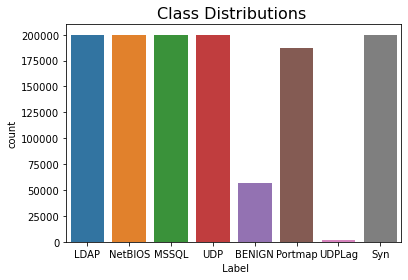

In [7]:
sns.countplot(x=' Label',data=df)
plt.title('Class Distributions ', fontsize=16)


# Preprocessing :

In [8]:

def encodage(df):
    code ={'BENIGN':0, 
       'LDAP': 1,
       'NetBIOS':2,
       'MSSQL':3,
       'UDP':4,
       'Portmap':2,
       'UDPLag':5,
       'Syn':6
       }
    
    df[' Label'] = df[' Label'].map(code)
   
    return df

df.dtypes.value_counts()

float64    45
int64      34
object      1
dtype: int64

In [9]:
df = encodage(df)   
y = df[' Label'] 
X= df.drop(' Label', axis=1)

In [10]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros= ros.fit_resample(X, y)
y_ros.value_counts()

1    386960
2    386960
3    386960
4    386960
0    386960
5    386960
6    386960
Name:  Label, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=4)

In [12]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

# Modellisation :

In [13]:


Svm = LinearSVC(multi_class='ovr')
Knn = KNeighborsClassifier()
DecisionTree = DecisionTreeClassifier(random_state=0)
LogReg = LogisticRegression(multi_class='multinomial')
GaussNB = GaussianNB()

In [14]:
dict_of_models = {
                  'DecisionTree': DecisionTree,
                  'SVM': Svm,
                  'KNN': Knn,
                  'GaussNB': GaussNB,
                  'LogReg' : LogReg
                  }


# Procédure d'évaluation :

In [15]:

def evaluation_valid(model, name=None):
    if name is None:
        name = model.__class__.__name__

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

    

    with open('model_'+name+'.pkl', 'rb') as f:
        model = pickle.load(f)

    # Make predictions on validation data (X_test)
    y_pred = model.predict(X_test)

    # f1-score
    f1 = f1_score(y_test, y_pred, average='micro')
    print(f" f1-Score: {f1}")


    # plot confusion matrix for validation set
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix, annot=True, fmt=".0f", ax=axes[0])
    axes[0].set_title(f"{name} Confusion Matrix (Validation Set)")

    # plot classification report for validation set
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    sns.heatmap(report_df, annot=True, cmap='Blues', ax=axes[1])
    axes[1].set_title(f"{name} Classification Report (Validation Set)")

    # plot normalized confusion matrix for validation set
    cm_normalized = cf_matrix / np.sum(cf_matrix, axis=1).reshape(-1, 1)
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', ax=axes[2])
    axes[2].set_title(f"{name} Normalized Confusion Matrix (Validation Set)")

        
    plt.show()



 f1-Score: 0.4284551374819103


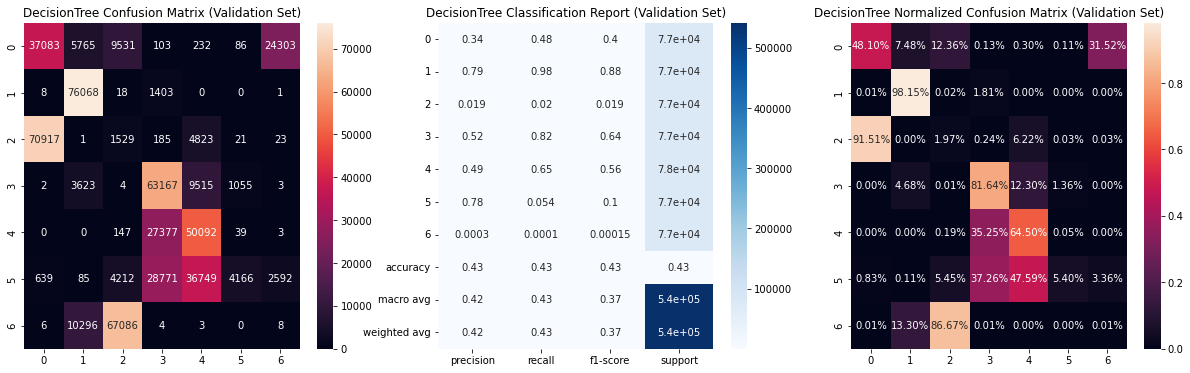

 f1-Score: 0.5691415133347116


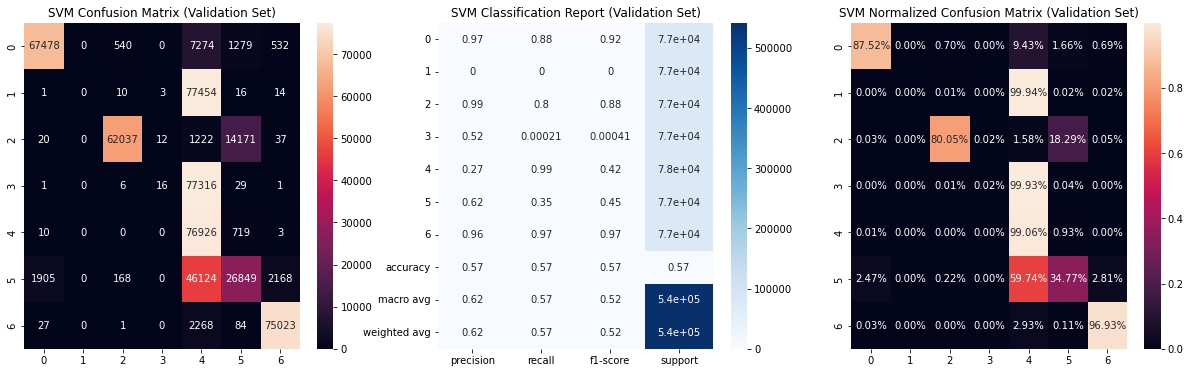

 f1-Score: 0.7828679228565522


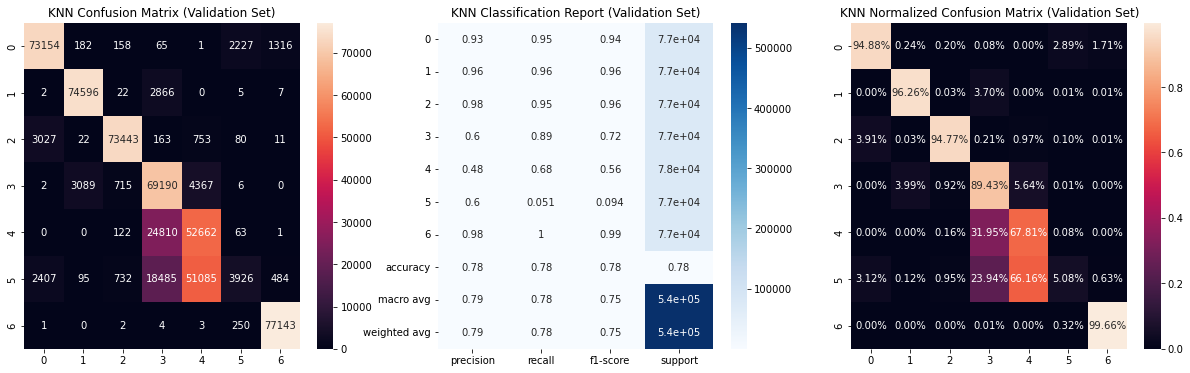

 f1-Score: 0.14232552644791635


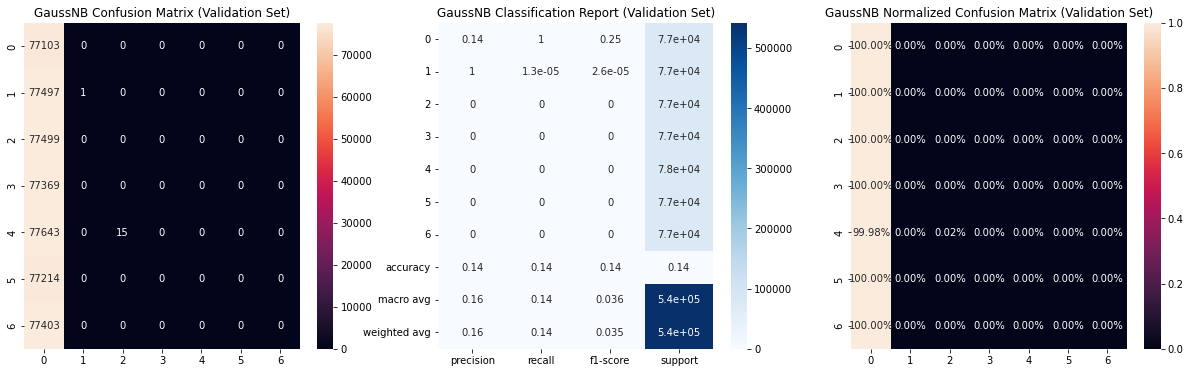

 f1-Score: 0.8533144806403026


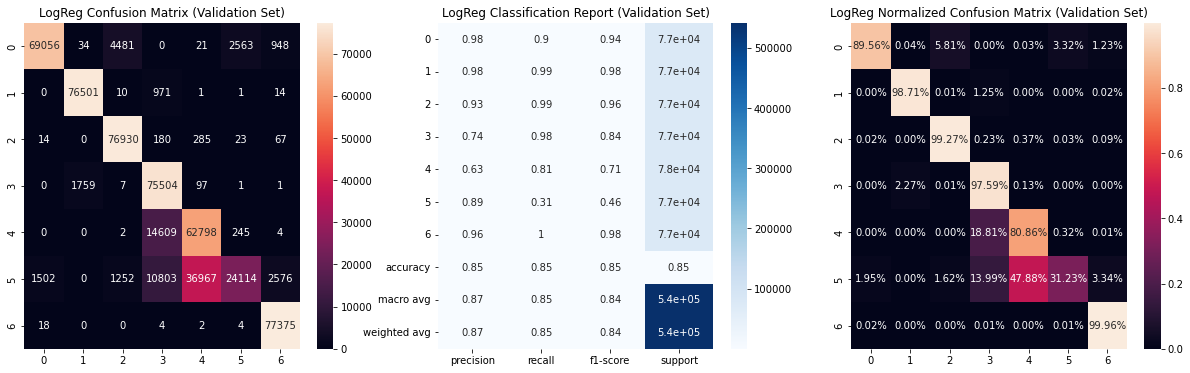

In [16]:
# Iterate over all models in dict_of_models
for name, model in dict_of_models.items():
    evaluation_valid(model,name)
    